# mallas

> Funciones para obtener variables de uso de suelo agregadas en mallas. 

In [ ]:
#| default_exp mallas

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
from pyLandUseMX.descargas import *
import warnings

In [ ]:
%load_ext autoreload
%autoreload 2

Algunos tipos de análisis, como las regresiones de uso de suelo para contaminantes atomsféricos, utilizan datos de uso de suelo en mallas. Para este tipo de aplicaciones la librería provee un conjunto de herramientas para crear mallas y agregar datos en ellas.

## grid_from_layer

In [ ]:
#| export
def grid_from_layer(layer: gpd.GeoDataFrame, # Capa que define la extensión espacial de la malla
                    size: float # Tamaño de los elementos de la malla (en las unidades de la proyección de `layer`)
                    ) -> gpd.GeoDataFrame:
    """ 
    Regresa un GeoDataFrame con la malla de la extensión de la capa (`layer`) que se le pase y de tamaño `size`.
    
    """
    xmin, ymin, xmax, ymax = layer.total_bounds
    cols = list(np.arange(xmin, xmax + size, size))
    rows = list(np.arange(ymin, ymax + size, size))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x + size, y), (x + size, y + size), (x, y + size)]))

    grid = (gpd
           .GeoDataFrame({'geometry':polygons})
           .set_crs(layer.crs)
           .reset_index()
           .rename({'index':'grid_id'}, axis=1))
    return grid

Probemos la función utilizando los polígonos de las 100 ciudades más grandes de Mérxico y seleccionando uno.

El archivo ya está descargado


<AxesSubplot:>

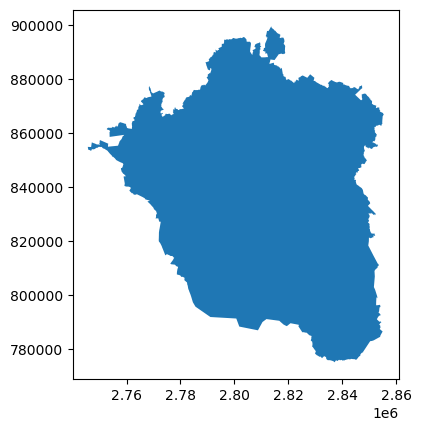

In [ ]:
descarga_poligonos_ciudades()
zmvm = gpd.read_file("datos/descargas/silhuetas.shp.zip")
zmvm = zmvm.loc[zmvm.CVE_SUN == '13']
zmvm.plot()

Pasamos el polígono a la función `grid_from_layer` para construir la malla y graficamos las dos capas juntas.

<AxesSubplot:>

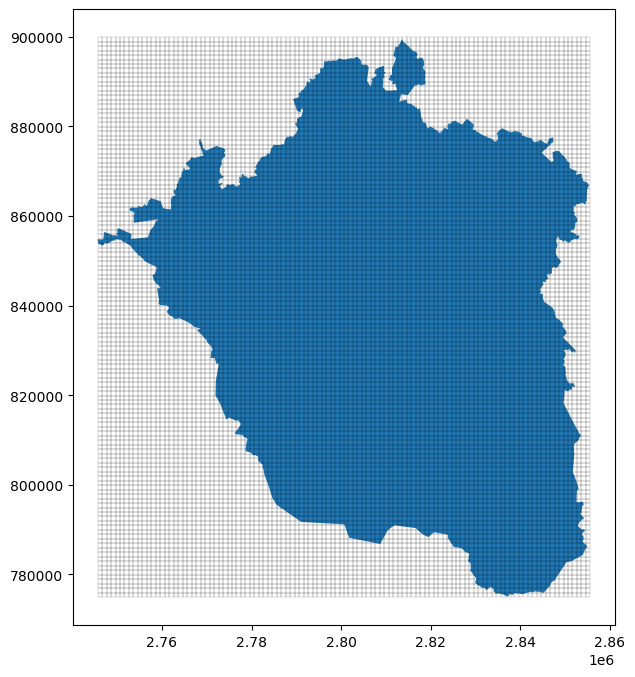

In [ ]:
malla = grid_from_layer(zmvm, 1000)
fig, ax = plt.subplots(figsize=(8, 8))
zmvm.plot(ax=ax)
malla.boundary.plot(ax=ax, edgecolor="black", linewidth=0.1)

## puntos_a_malla

Una vez que tenemos definida la malla, podemos tomar una capa de puntos y calcular la cantidad de puntos en cada elemento de la retícula. 

In [ ]:
#| export
def puntos_a_malla(grid:gpd.GeoDataFrame, # La malla en la que se va a agregar
                   puntos:gpd.GeoDataFrame # La capa de puntos a agregar
                   )-> gpd.GeoDataFrame:
    if grid.crs != puntos.crs:
        puntos = puntos.to_crs(grid.crs)
    agregado = (puntos
                .to_crs(malla.crs)
                .sjoin(malla)
                .groupby('grid_id')
                .size()
                .reset_index()
                .rename({0:'cuenta'}, axis=1)
                .merge(malla, on='grid_id', how='right').fillna(0))
    agregado = (gpd.GeoDataFrame(agregado)
               .set_crs(malla.crs))
    return agregado

Cargamos una capa de puntos de ejemplo y la agregamos en la malla que construimos

In [ ]:
puntos = gpd.read_file("datos/points_sample.zip")
agregados = puntos_a_malla(malla, puntos)
agregados

,grid_id,cuenta,geometry
0,0,0.0,"POLYGON ((2745631.810 774927.105, 2746631.810 ..."
1,1,0.0,"POLYGON ((2745631.810 775927.105, 2746631.810 ..."
2,2,0.0,"POLYGON ((2745631.810 776927.105, 2746631.810 ..."
3,3,0.0,"POLYGON ((2745631.810 777927.105, 2746631.810 ..."
4,4,0.0,"POLYGON ((2745631.810 778927.105, 2746631.810 ..."
...,...,...,...
13745,13745,0.0,"POLYGON ((2854631.810 894927.105, 2855631.810 ..."
13746,13746,0.0,"POLYGON ((2854631.810 895927.105, 2855631.810 ..."
13747,13747,0.0,"POLYGON ((2854631.810 896927.105, 2855631.810 ..."
13748,13748,0.0,"POLYGON ((2854631.810 897927.105, 2855631.810 ..."


Podemos hacer un mapa con estos agregados

<AxesSubplot:>

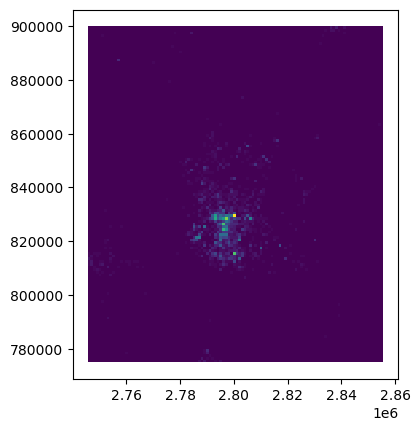

In [ ]:
agregados.plot('cuenta')

## lineas_a_malla

Esta función se encarga de agregar una capa de líneas en una malla. Calcula la longitud de las líneas adentro de cada cuadrado de la retícula y utiliza ese valor en la malla. Sirve, por ejemplo, para calcular la longitud total de un tipo de vialidad en cada elemento de la malla. 

In [ ]:
#| export
def lineas_a_malla(lineas:gpd.GeoDataFrame, # La capa de líneas a agregar
                   malla: gpd.GeoDataFrame # La malla para la agregación
                   ):
    """ Regresa la malla con la longitud de las lineas agregadas en cada elemento. """ 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        union = (red
                .to_crs(malla.crs)
                .overlay(malla, how='union')
                .dissolve(by='grid_id')
                .length.reset_index()
                .rename({0:'longitud'}, axis=1)   
            )
    union = (malla
            .merge(union, on='grid_id', how='left')
            .fillna(0)
        )
    return union

Para ver cómo se usa la función, vamos a leer la red de OSM que descargamos y filtrar sólo las vialidades primarias

<AxesSubplot:>

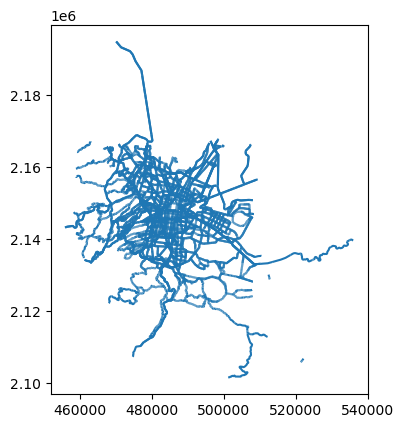

In [ ]:
descarga_redes() # nos aseguramos de tener la red
red = gpd.read_file("datos/descargas/red_zmvm.gpkg")
red = red.loc[red.tag_id.isin([104,108,106,101])]
red.plot()

Ahora podemos agregar la red en nuestra malla

In [ ]:
red_malla = lineas_a_malla(red, malla)
red_malla

,grid_id,geometry,longitud
0,0,"POLYGON ((2745631.810 774927.105, 2746631.810 ...",0.0
1,1,"POLYGON ((2745631.810 775927.105, 2746631.810 ...",0.0
2,2,"POLYGON ((2745631.810 776927.105, 2746631.810 ...",0.0
3,3,"POLYGON ((2745631.810 777927.105, 2746631.810 ...",0.0
4,4,"POLYGON ((2745631.810 778927.105, 2746631.810 ...",0.0
...,...,...,...
13745,13745,"POLYGON ((2854631.810 894927.105, 2855631.810 ...",0.0
13746,13746,"POLYGON ((2854631.810 895927.105, 2855631.810 ...",0.0
13747,13747,"POLYGON ((2854631.810 896927.105, 2855631.810 ...",0.0
13748,13748,"POLYGON ((2854631.810 897927.105, 2855631.810 ...",0.0


El `GeoDataFrame` que nos regresa sólo tiene el id de la malla y la longitud de la red dentro de cada elemento de la retícula. Lo podemos ver rápidamente en un mapa

<AxesSubplot:>

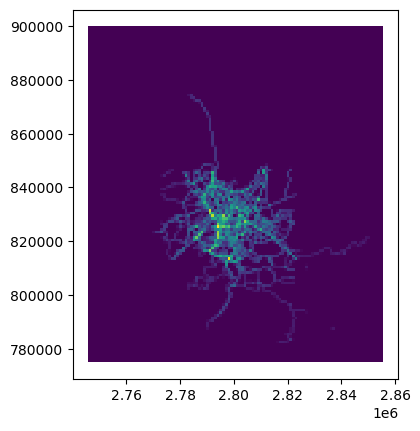

In [ ]:
red_malla.plot('longitud')